In [124]:
import sklearn
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='white')

In [125]:
digits = load_digits()
print (digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [126]:
threes = np.array([images[i] for i in range (len(images)) if target[i] == 3])
nines = np.array([images[i] for i in range (len(images)) if target[i] == 9])

print(threes.shape)
print(nines.shape)

(183, 8, 8)
(180, 8, 8)


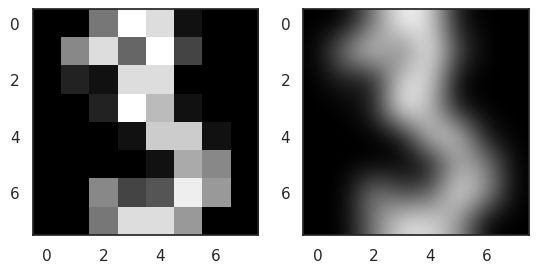

In [127]:
img = threes[0]
assert 2 == len(img.shape)

## plot image side by side with neareste and bicubic interpolation
plt.figure()
plt.gray()
plt.subplot(1,2,1)
plt.imshow(img, interpolation="nearest" )
plt.subplot(1,2,2)
plt.imshow(img, interpolation="bicubic" ) 
plt.show()

In [128]:
from sklearn import model_selection

filter_indices = np.where((digits.target == 3) | (digits.target == 9))[0]
filtered_data = digits.data[filter_indices]
filtered_target = digits.target[filter_indices]

X_train, X_test, y_train, y_test = model_selection.train_test_split(filtered_data, filtered_target, test_size=0.4,random_state=0)

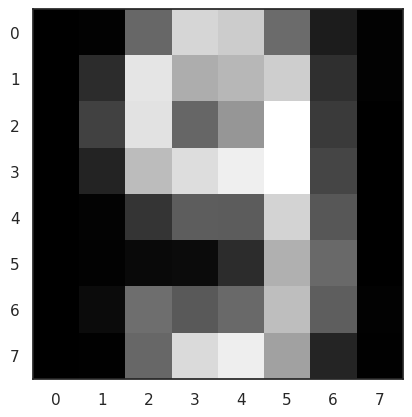

In [129]:
## explore mean image of 9s
mean_nine = np.mean(nines, axis=0)
plt.figure()
plt.gray()
plt.imshow(mean_nine,interpolation="nearest")

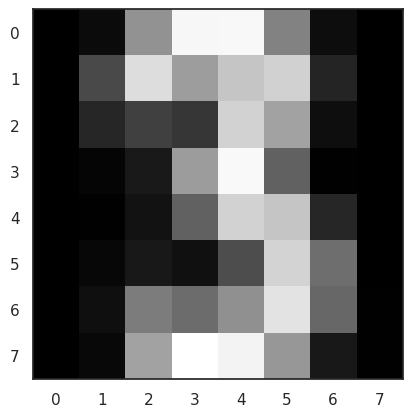

In [130]:
## explore mean image of 3s
threes_mean = np.mean(threes, axis=0)
# threes_mean[0,4] = 0 ## primu indice e pe oy, al doilea pe ox
plt.figure()
plt.gray()
plt.imshow(threes_mean,interpolation="nearest")

In [131]:
def features2d(x):
    '''
    candidate pixels: 
    
    (2,2) - bright in nine, dark in three
    (3,2) - bright in nine, dark in three
    (3,5) - bright in nine, gray in three - less
    (2,5) - bright in nine, gray in three - less 

    max value: 16
    min value: 0
    '''

    x_ = x.reshape(-1,8,8)
    
    f1 = 0.5*(x_[:,2,2] + x_[:,3,2]) ## [0,16]
    f2 = x_[:,3,5] + x_[:,2,5] ## [0,32]
    return np.column_stack((f1,f2))

def transform_labels(y):
    y[y == 3] = -1
    y[y == 9] = 1
    return y


def get_bisector(a,b):
    return (a + b)/np.linalg.norm(a + b)

def get_clusters(training_features,training_labels):
    mean_3 = np.mean(training_features[training_labels == -1],axis=0)
    mean_9 = np.mean(training_features[training_labels == 1],axis=0)

    return mean_3,mean_9

def error(labels,predicted_labels):
    return np.sum(labels != predicted_labels)/labels.shape[0]

def nearest_mean(training_features,training_labels,test_features):
    mean_3 = np.mean(training_features[training_labels == -1],axis=0)
    mean_9 = np.mean(training_features[training_labels == 1],axis=0)

    bisector = get_bisector(mean_3,mean_9)

    ## assign each test_feature to the closest mean
    test_labels = np.zeros(test_features.shape[0])
    predicted_train_lables = np.zeros(training_features.shape[0])
    for i in range(test_features.shape[0]):
        dist_3 = np.linalg.norm(test_features[i] - mean_3)
        dist_9 = np.linalg.norm(test_features[i] - mean_9)
        test_labels[i] = -1 if dist_3 < dist_9 else 1

    for i in range(training_features.shape[0]):
        dist_3 = np.linalg.norm(training_features[i] - mean_3)
        dist_9 = np.linalg.norm(training_features[i] - mean_9)
        predicted_train_lables[i] = -1 if dist_3 < dist_9 else 1

    print("Training error: ",error(training_labels,predicted_train_lables))

    
    return test_labels

(217, 2)


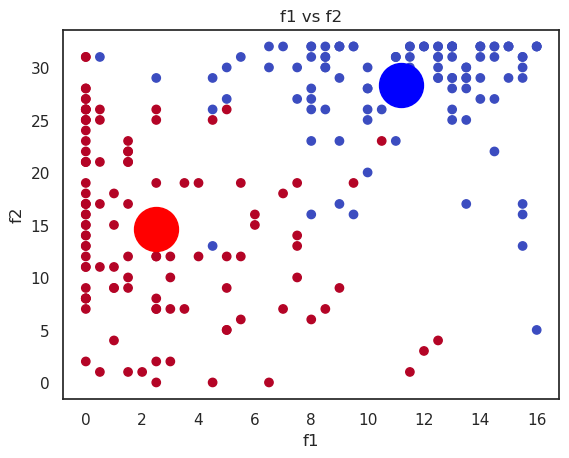

In [132]:
## TODO: add legend to plot

features = features2d(X_train)
print(features.shape)
## make a scatter plot of the features
plt.figure()
plt.scatter(features[:,0], features[:,1], c=~y_train, cmap="coolwarm")
## plot the mean of the classes
plt.scatter(np.mean(features[y_train == 3],axis=0)[0],np.mean(features[y_train == 3],axis=0)[1],c="red",marker="o",s=1000)
plt.scatter(np.mean(features[y_train == 9],axis=0)[0],np.mean(features[y_train == 9],axis=0)[1],c="blue",marker="o",s=1000)
## make legend for each class
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("f1 vs f2")
plt.show()

In [133]:
from pprint import pprint
## NOTE: the error is not normalized
print("Note that error in not normalized")
predicted_test_labels = nearest_mean(features2d(X_train),transform_labels(y_train),features2d(X_test))
print("Testing error:",error(transform_labels(y_test),predicted_test_labels))

Note that error in not normalized
Training error:  0.10599078341013825
Testing error: 0.07534246575342465


Training error:  0.10599078341013825


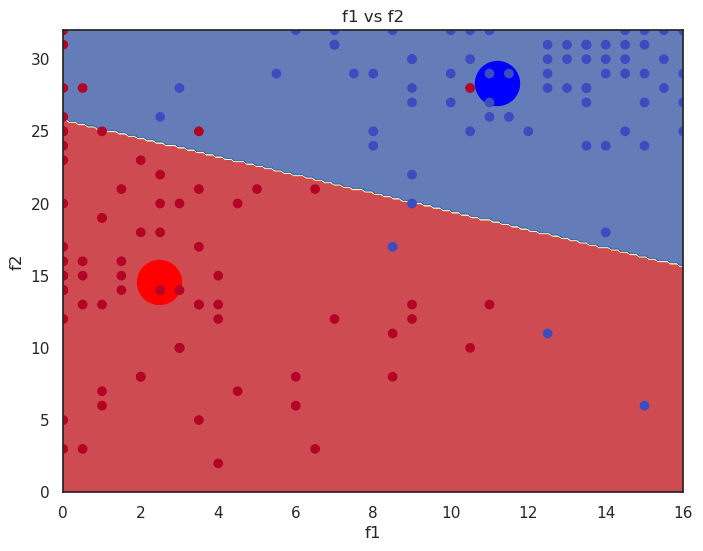

In [134]:
x_lim = 16
y_lim = 32

## TODO: either add transformation from feature space to grid space or play with limits

xx, yy = np.meshgrid(np.linspace(0, x_lim, 200), np.linspace(0, y_lim, 200))
grid_features = np.c_[xx.ravel(), yy.ravel()]
grid_prediction = nearest_mean(features2d(X_train),transform_labels(y_train),grid_features)
grid_prediction = grid_prediction.reshape(xx.shape)

mean_3,mean_9 = get_clusters(features2d(X_train),transform_labels(y_train))

## create a transformation from the feature space to the grid space
# Plot the decision regions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_prediction, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.scatter(mean_3[0],mean_3[1],c="red",marker="o",s=1000)
plt.scatter(mean_9[0],mean_9[1],c="blue",marker="o",s=1000)
## plot test data
plt.scatter(features2d(X_test)[:,0], features2d(X_test)[:,1], c=~y_test, cmap="coolwarm")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("f1 vs f2")
plt.show()